In [ ]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import PartialDependenceDisplay

In [ ]:
df = pd.read_csv('healthcare-stroke-data.csv')
df['gender'] = (df['gender'] == 'Male') * 1.  # 1 Male | 0 Female
df['ever_married'] = (df['ever_married'] == 'Yes') * 1.0
df['residence_type'] = (df['Residence_type'] == 'Urban') * 1.0

df.drop(['Residence_type', 'id'], axis=1, inplace=True)
df_train, df_test = train_test_split(df, test_size=.25, random_state=26)
df_train, df_valid = train_test_split(df_train, test_size=.3, random_state=26)


In [ ]:
X, y = df_train.drop('stroke', axis=1), df_train['stroke'].values

In [ ]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,residence_type
2393,0.0,41.0,0,0,1.0,Private,140.93,46.5,Unknown,1.0
3535,0.0,49.0,0,0,1.0,Private,85.23,25.4,Unknown,0.0
923,1.0,71.0,0,1,1.0,Self-employed,207.32,32.4,smokes,0.0
1604,0.0,47.0,0,0,1.0,Private,65.04,30.9,never smoked,1.0
3670,0.0,51.0,0,0,1.0,Govt_job,92.95,23.9,never smoked,0.0


In [ ]:
# Define columns
cols_num = X.select_dtypes(np.number).columns.tolist()
cols_cat = X.select_dtypes(['object', 'category']).columns.tolist()

# Preprocessing for numerical columns: Median Imputation
num_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical columns: Most Frequent Imputation + Ordinal Encoding
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine transformers into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, cols_num),
    ('cat', cat_transformer, cols_cat)
])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor(random_state=42))
])

X = X[cols_num + cols_cat]

model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['gender', 'age',
                                                   'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'avg_glucose_level', 'bmi',
                                                   'residence_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('classifier', DecisionTreeRegressor(random_state=42))])

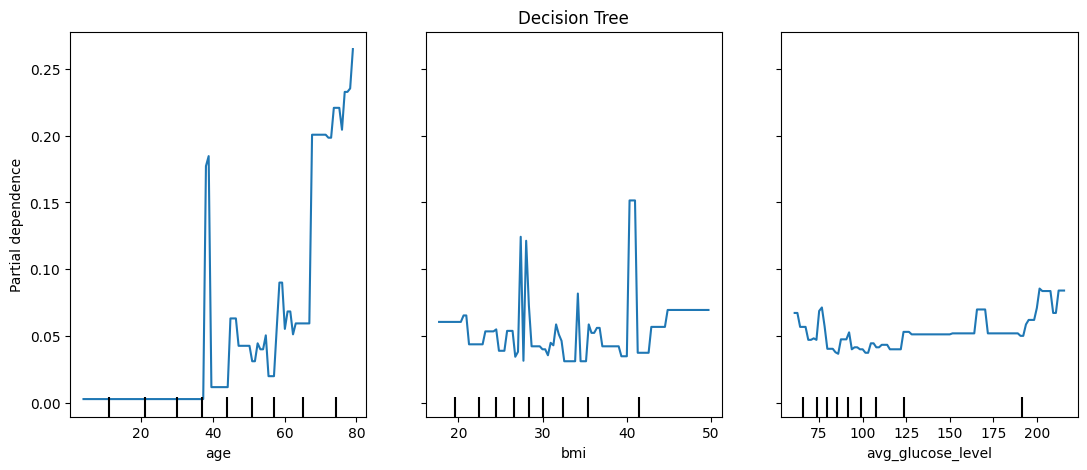

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.set_title('Decision Tree')
tree_disp = PartialDependenceDisplay.from_estimator(model, X, ['age', 'bmi', 'avg_glucose_level'], ax=ax)

In [ ]:
# Define columns
cols_num = X.select_dtypes(np.number).columns.tolist()
cols_cat = X.select_dtypes(['object', 'category']).columns.tolist()

# Preprocessing for numerical columns: Median Imputation
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical columns: Most Frequent Imputation + Ordinal Encoding
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, cols_num),
    ('cat', cat_transformer, cols_cat)
])

# Define the model pipeline
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

X = X[cols_num + cols_cat]

model_lr.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'age',
                                                   'hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'avg_glucose_level', 'bmi',
                                                   'residence_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('classifier', LogisticRegression(random_state=42))])

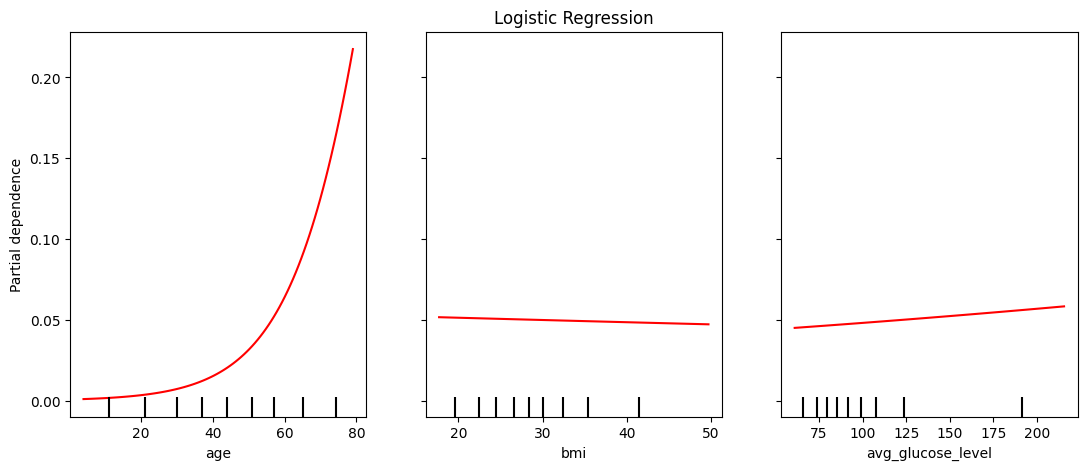

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.set_title('Logistic Regression')
lr_disp = PartialDependenceDisplay.from_estimator(
    model_lr, X, ['age', 'bmi', 'avg_glucose_level'], ax=ax, line_kw={'color': 'red'}
)

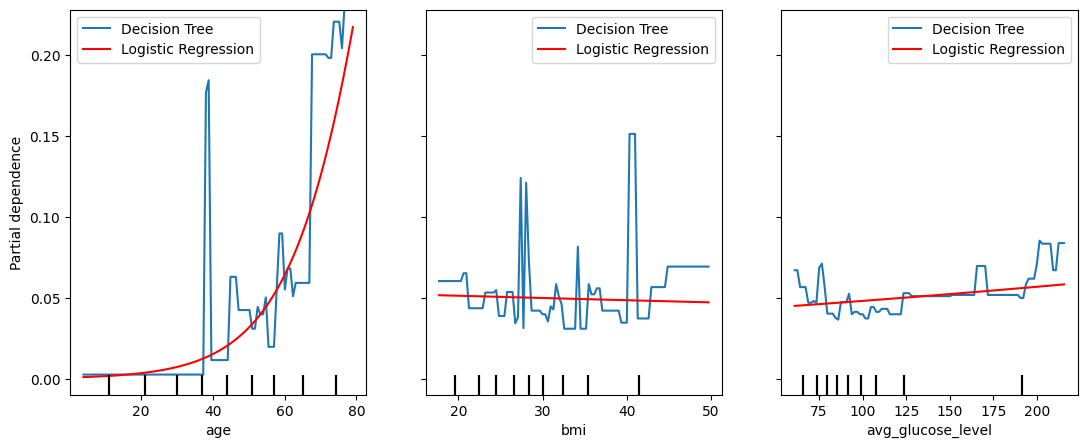

In [ ]:
tree_disp.plot(line_kw={'label': 'Decision Tree'})
lr_disp.plot(
    line_kw={'label': 'Logistic Regression', 'color': 'red'}, ax=tree_disp.axes_
)
tree_disp.figure_.set_size_inches(13, 5)
tree_disp.axes_[0, 0].legend()
tree_disp.axes_[0, 1].legend()
plt.show()

In [ ]:
"""
PDP is an average of the marginal effects of the features.
We are averaging the response of all samples of the provided set.
Thus, some effects could be hidden. In this regard, it is possible to plot each individual response.
This representation is called the Individual Effect Plot (ICE).
In the plot below, we plot 100 randomly selected ICEs for the age, bim and avg_glucose_level features.
"""

'\nPDP is an average of the marginal effects of the features.\nWe are averaging the response of all samples of the provided set.\nThus, some effects could be hidden. In this regard, it is possible to plot each individual response.\nThis representation is called the Individual Effect Plot (ICE).\nIn the plot below, we plot 100 randomly selected ICEs for the age, bim and avg_glucose_level features.\n'

Computing partial dependence plots and individual conditional expectation...
done in 3.547s


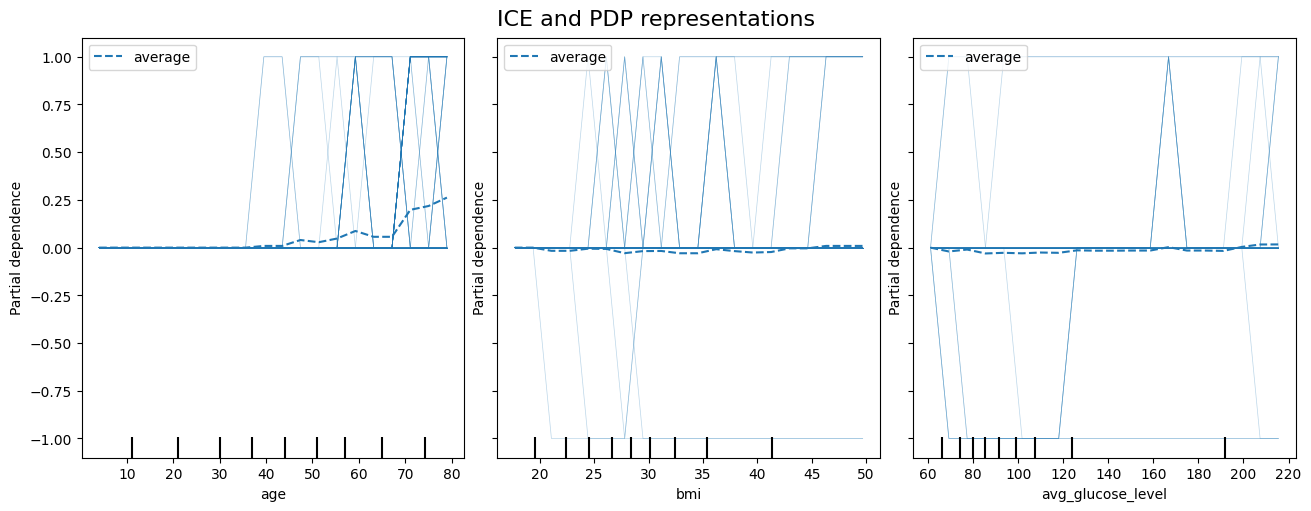

In [ ]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(13, 5), sharey=True, constrained_layout=True)

features_info = {
    'features': ['age', 'bmi', 'avg_glucose_level'],
    'kind': 'both',
    'centered': True,
}

common_params = {
    'subsample': 100,
    'n_jobs': 2,
    'grid_resolution': 20,
    'random_state': 23,
}

display = PartialDependenceDisplay.from_estimator(
    model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)
print(f'done in {time() - tic:.3f}s')
_ = display.figure_.suptitle('ICE and PDP representations', fontsize=16)

In [ ]:
"""
Multiple light-blue lines: These are the ICE (Individual Conditional Expectation) curves.
Each line shows how the model’s prediction for one particular instance changes as you vary that feature (while keeping all other features of that instance fixed).
A dashed blue line labeled “average”: This is the PDP (Partial Dependence Plot), i.e., the average of all the ICE curves at each feature value.
""";

In [ ]:
"""
3. Key Takeaways
- Heterogeneity:
ICE curves let you see how different individuals (or subgroups) respond differently to the same feature.
If many lines overlap, the feature has a consistent effect across individuals. If lines vary widely, there’s more heterogeneity.

- Threshold Behavior:
Step-like changes typically indicate threshold-based splits in the model (common in decision trees).

- Average vs. Individual:
The PDP (dashed line) can hide important nuances—
some people may have zero change, others a large jump at the same feature value, yet the average is somewhere in the middle.


Model Insights:
- Age seems to have the biggest average effect, with many lines jumping to higher stroke risk beyond certain ages.
- BMI is mostly flat on average, but a few lines do jump, showing the model has some rules around specific BMI thresholds.
- Glucose has a mild upward average effect, though certain individuals are more sensitive than others.

Overall, this comparison of ICE and PDP underscores how averaging can mask individual differences.
ICE plots are a powerful way to spot interactions or subgroups that might respond differently to a given feature.
""";

In [ ]:
"""
PDP and ICE plots are typically used after you have trained a model (or a set of candidate models)
and you want to understand or “explain” how each feature influences the model’s predictions.
They are part of the model interpretation or model debugging stage of the ML workflow—often right after or alongside model evaluation.
""";